## API

```julia
heuristic(sensitivity, budget, tradeoff_map)
```

Given the sensitivity values of each state, the overall budget for all states, and a tradeoff
map where the first column represents the accuracy values and the second column costs, return
the selected values for each state.

Example: 
```julia
julia> heuristic(
        [0.45, 0.29, 0.48, 0.68, 0.27],
        11,
        [0.0718114  0.39
         0.059322   0.7
         0.0537408  1.0
         0.0449321  1.8
         0.0373444  4.2])

4-element Vector{Int64}:
4
2
4
4
2
```

Two heuristics are provided in the notebook.

Full signature:
```julia
heuristic(sensitivity::Vector{<:Real}, budget::Real, tradeoff_map::Matrix{<:Real})
```

In [7]:
using JLD2
using FileIO
using Plots

## Analyzing selection heuristics

┌ Info: true
└ @ Main /Users/jerry/Projects/date24-asd/src/heuristics.ipynb:13


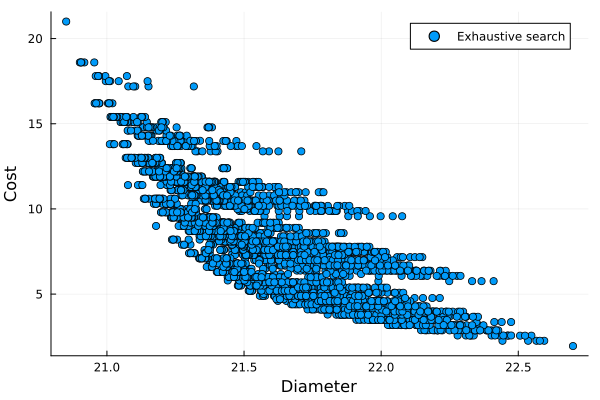

In [8]:
# Read the costs and diameters of experiment data
points = load("../data/exhaustive_points.jld2", "points")[:,2:end]

diameters = zeros(5, 5, 5, 5, 5)
costs = zeros(5, 5, 5, 5, 5)

for i in axes(points, 2)
    coord = points[1, i]
    diameters[coord...] = points[2, i]
    costs[coord...] = points[3, i]
end

@info diameters[:] == points[2,:] && costs[:] == points[3,:]
scatter(diameters[:], costs[:], xlabel="Diameter", ylabel="Cost", label="Exhaustive search")

In [9]:
efficient_net_surfaces = (
    B0 = (acc1 = 77.1, acc5 = 93.3, para = 5.3, flop = 0.39),
    B1 = (acc1 = 79.1, acc5 = 94.4, para = 7.8, flop = 0.70),
    B2 = (acc1 = 80.1, acc5 = 94.9, para = 9.2, flop = 1.0),
    B3 = (acc1 = 81.6, acc5 = 95.7, para = 12, flop = 1.8),
    B4 = (acc1 = 82.9, acc5 = 96.4, para = 19, flop = 4.2),
    B5 = (acc1 = 83.6, acc5 = 96.7, para = 30, flop = 9.9),
    B6 = (acc1 = 84.0, acc5 = 96.8, para = 43, flop = 19),
    B7 = (acc1 = 84.3, acc5 = 97.0, para = 66, flop = 37),
)

efficient_net_map_full = vcat(([100/b.acc1 - 1;; 100/b.acc5 - 1;; b.flop] for b in efficient_net_surfaces)...)
efficient_net_map = efficient_net_map_full[1:5,2:3]

5×2 Matrix{Float64}:
 0.0718114  0.39
 0.059322   0.7
 0.0537408  1.0
 0.0449321  1.8
 0.0373444  4.2

## Heuristics


### Heuristic 1
$$
B_i = B \frac{S_i}{\sum_j S_j}
$$

What if the accuracy-efficiency tradeoff-map is given? We will have to select the discrete points?

Selection process:

1. Select the least expensive option for each state.
2. Starting from the most sensitive state, select the most expensive NN that is no more expensive than the individual budget allows, if the overall budget still has enough headroom (which might be violated by step-1).
3. Starting from the most sensitive state, select the NN that is one level higher than the current level, if the overall budget has enough headroom.

In [10]:
# Split budget according to sensitivity
heuristic1(sensitivity::Vector{<:Real}, budget::Real) = budget / sum(sensitivity) .* sensitivity
heuristic1(sensitivity::Vector{<:Real}, budget::Real, tradeoff_map::Nothing) = heuristic1(sensitivity, budget)
heuristic1(sensitivity::Vector{<:Real}, budget::Real, tradeoff_map::Matrix{<:Real}) = let
    cost(level) = tradeoff_map[level, 2]
    state_budgets = heuristic1(sensitivity, budget)

    # 1. Select the least expensive option for all states.
    levels = ones(Int64, size(sensitivity))
    nlevels = size(tradeoff_map, 1)

    # 2. Select the most expensive option within individual budget
    rankings = sortperm(sensitivity, rev=true)
    for state in rankings
        other_costs = sum(map(cost, levels)) - cost(levels[state])
        while levels[state] < nlevels && cost(levels[state] + 1) <= min(state_budgets[state], budget - other_costs)
            levels[state] += 1
        end
    end

    # 3. Any addtional increases
    for i in 1:nlevels, state in rankings
        other_costs = sum(map(cost, levels)) - cost(levels[state])
        if levels[state] < nlevels && cost(levels[state] + 1) <= budget - other_costs
            levels[state] += 1
        end
    end
    levels
end


heuristic1 (generic function with 3 methods)

### Heuristic 2

Process

1. Select the least expensive option for each state.
2. Starting from the most sensitive state, select the most expensive NN allowed by the remaining budget. Continue until all states have been considered.

In [11]:
heuristic2(sensitivity::Vector{<:Real}, budget::Real, tradeoff_map::Matrix{<:Real}) = let
    cost(level) = tradeoff_map[level, 2]

    # 1. Select the least expensive option for all states
    levels = ones(Int64, size(sensitivity))
    nlevels = size(tradeoff_map, 1)

    # 2. Choose the most expensive network that can be afforded, iterating from most sensitive state
    rankings = sortperm(sensitivity, rev=true) # Return the ordering of states by their index
    for state in rankings
        other_costs = sum(map(cost, levels)) - cost(levels[state])
        while levels[state] < nlevels && cost(levels[state] + 1) <= budget - other_costs
            levels[state] += 1
        end
    end
    levels
end

heuristic2 (generic function with 1 method)

### Evaluate heuristics

┌ Info: best
│   collect(best_coord) = [4, 4, 4, 4, 2]
└ @ Main /Users/jerry/Projects/date24-asd/src/heuristics.ipynb:29
┌ Info: h1add
│   selection = [4, 2, 4, 4, 4]
└ @ Main /Users/jerry/Projects/date24-asd/src/heuristics.ipynb:41
┌ Info: h1mul
│   selection = [3, 3, 3, 5, 2]
└ @ Main /Users/jerry/Projects/date24-asd/src/heuristics.ipynb:41
┌ Info: h2add
│   selection = [4, 1, 1, 5, 3]
└ @ Main /Users/jerry/Projects/date24-asd/src/heuristics.ipynb:41
┌ Info: h2mul
│   selection = [3, 1, 4, 5, 1]
└ @ Main /Users/jerry/Projects/date24-asd/src/heuristics.ipynb:41


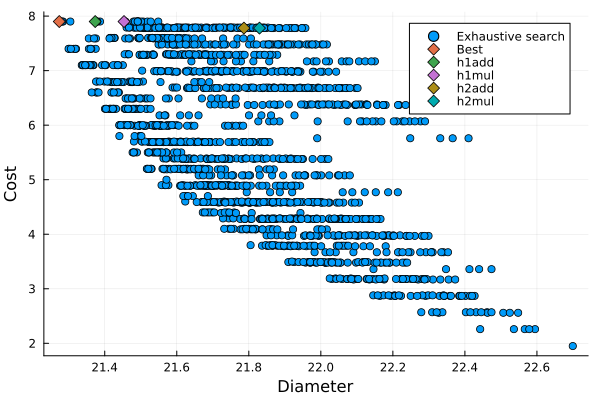

In [15]:
function mark_point!(plt::Plots.Plot, selection::Vector{<:Real}, label::String)
    scatter!([diameters[selection...]], [costs[selection...]], label=label, marker=(:diamond, 6))
end

# Two sensitivities
mul_sensitivity = [0.45, 0.29, 0.48, 0.68, 0.27]
add_sensitivity = [0.35, 0.0, 0.23, 0.52, 0.32]
budget = 8

# Draw all points from the exhaustive search as baseline
filter = costs .<= budget
plt = scatter(
    diameters[filter][:], 
    costs[filter][:], 
    xlabel="Diameter", 
    ylabel="Cost", 
    label="Exhaustive search")
    
# Find the best strategy
best = Inf
best_coord = 0
for i in axes(points, 2)
    coord = points[1, i]
    if costs[coord...] <= budget && diameters[coord...] < best
        best_coord = coord
        best = diameters[coord...]
    end
end
@info "best" collect(best_coord)
mark_point!(plt, collect(best_coord), "Best")

# Construction combinations of sensitivities and heuristics
heuristics = [("h1", heuristic1), ("h2", heuristic2)]
sensitivities = [("add", add_sensitivity), ("mul", mul_sensitivity)]
combos = Iterators.product(sensitivities, heuristics)

# Draw combinations on diagram
for combo in combos
    selection = combo[2][2](combo[1][2], budget, efficient_net_map)
    label = combo[2][1] * combo[1][1]
    @info label selection
    mark_point!(plt, selection, label)
end

# Show plot
savefig(plt, "plot.pdf")
plt

## Sensitivity Calculation

In [ ]:
using PyCall
pushfirst!(pyimport("sys")."path", @__DIR__)
ordunc = pyimport("OrderUncertainties")

function get_sensitivity(A_phi, Y)
    mat = ordunc.OrdUnc(A_phi)
    if mat.determineCase() == 1
        return mat.distinctPos(Y)
    else
        return mat.mulSig(Y)
    end
end

get_sensitivity (generic function with 1 method)

In [ ]:
A = [1 2; 3 4]
Y = A
get_sensitivity(A, Y)

-0.12308774997837633